- <https://github.com/DataTalksClub/machine-learning-zoomcamp/tree/master/04-evaluation>
- <https://www.evidentlyai.com/classification-metrics/explain-roc-curve#:~:text=The%20ROC%20AUC%20score%20is%20the%20area%20under%20the%20ROC,and%201%20indicates%20perfect%20performance.>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [5]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(max_iter=20_000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=20000)

In [6]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8041163946061036)

# Accuracy

In [7]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).mean()

np.float64(0.8041163946061036)

In [10]:
(y_val == churn_decision).sum()

np.int64(1133)

In [19]:
y_val.mean()

np.float64(0.2739531582682754)

In [11]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [14]:
from sklearn.metrics import accuracy_score

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.512
0.10 0.607
0.15 0.661
0.20 0.703
0.25 0.735
0.30 0.759
0.35 0.766
0.40 0.781
0.45 0.791
0.50 0.804
0.55 0.801
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


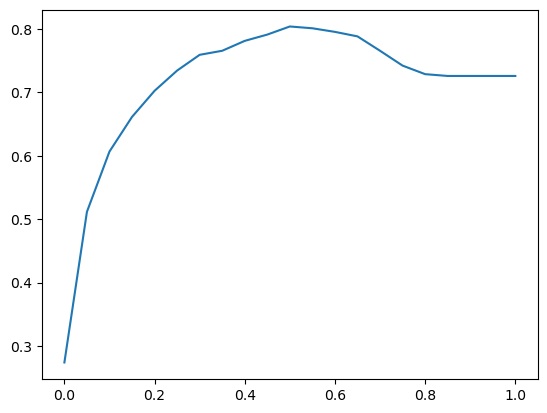

In [15]:
plt.plot(thresholds, scores)

In [16]:
from collections import Counter

In [17]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [31]:
t = 0.5

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
predicted_positive = (y_pred >= t)
predicted_negative = (y_pred < t)

print(sum(actual_positive))
print(sum(actual_negative))
print(sum(predicted_positive))
print(sum(predicted_negative))

386
1023
314
1095


In [27]:
true_positive = predicted_positive & actual_positive
sum(true_positive)

np.int64(212)

In [28]:
true_negative = predicted_negative & actual_negative
sum(true_negative)

np.int64(921)

In [29]:
false_positive = predicted_positive & actual_negative
sum(false_positive)

np.int64(102)

In [30]:
false_negative = predicted_negative & actual_positive
sum(false_negative)

np.int64(174)

In [33]:
confusion_matrix = np.array([
    [sum(true_negative), sum(false_positive)],
    [sum(false_negative), sum(true_positive)]
])
confusion_matrix # high % of false negs

array([[921, 102],
       [174, 212]])

In [35]:
(confusion_matrix / confusion_matrix.sum()).round(2)

# acc = tp% + tn%

array([[0.65, 0.07],
       [0.12, 0.15]])

In [36]:
prec = true_positive.sum() / (true_positive.sum() + false_positive.sum())
prec

np.float64(0.6751592356687898)

In [37]:
rec = true_positive.sum() / (true_positive.sum() + false_negative.sum())
rec

np.float64(0.5492227979274611)

In [38]:
# 55% of churners correctly flagged

tpr = true_positive.sum() / actual_positive.sum()
tpr

np.float64(0.5492227979274611)

In [39]:
# 10% of "good" customers predicted as churning

fpr = false_positive.sum() / actual_negative.sum()
fpr

np.float64(0.09970674486803519)

In [42]:
thresholds = np.linspace(0, 1, 101)

scores = []
for t in thresholds:
    ap = (y_val == 1)
    an = (y_val == 0)
    pp = (y_pred >= t)
    pn = (y_pred < t)
    tp = (pp & ap).sum()
    tn = (pn & an).sum()
    fp = (pp & an).sum()
    fn = (pn & ap).sum()
    scores.append((t, tp, fp, fn, tn))
    

In [43]:
scores[:5]

[(np.float64(0.0), np.int64(386), np.int64(1023), np.int64(0), np.int64(0)),
 (np.float64(0.01), np.int64(385), np.int64(895), np.int64(1), np.int64(128)),
 (np.float64(0.02), np.int64(383), np.int64(804), np.int64(3), np.int64(219)),
 (np.float64(0.03), np.int64(382), np.int64(750), np.int64(4), np.int64(273)),
 (np.float64(0.04), np.int64(382), np.int64(710), np.int64(4), np.int64(313))]

In [47]:
cols = ["thr", "tp", "fp", "fn", "tn"]
df = pd.DataFrame(scores, columns=cols)
df["tpr"] = df.tp / (df.tp + df.fn)
df["fpr"] = df.fp / (df.fp + df.tn)
df[::10]

,thr,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,534,20,489,0.948187,0.521994
20,0.2,339,372,47,651,0.878238,0.363636
30,0.3,292,245,94,778,0.756477,0.239492
40,0.4,253,175,133,848,0.655440,0.171065
50,0.5,212,102,174,921,0.549223,0.099707
60,0.6,151,53,235,970,0.391192,0.051808
70,0.7,69,13,317,1010,0.178756,0.012708
80,0.8,4,0,382,1023,0.010363,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


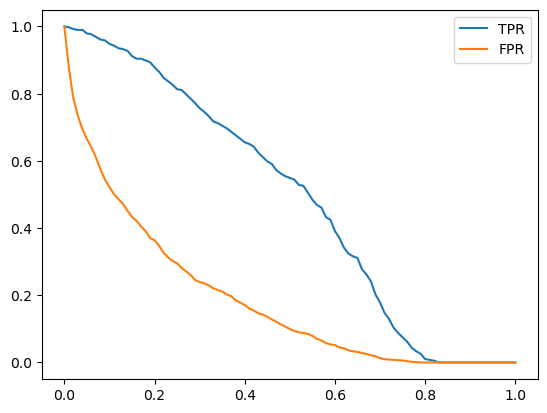

In [49]:
plt.plot(df.thr, df.tpr, label="TPR")
plt.plot(df.thr, df.fpr, label="FPR")
plt.legend()

In [50]:
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [52]:
random_model_acc = accuracy_score(y_val, y_rand >= 0.5)
random_model_acc

0.5017743080198722

In [53]:
def tpr_fpr(y_val, y_pred):
    thresholds = np.linspace(0, 1, 101)
    scores = []
    for t in thresholds:
        ap = (y_val == 1)
        an = (y_val == 0)
        pp = (y_pred >= t)
        pn = (y_pred < t)
        tp = (pp & ap).sum()
        tn = (pn & an).sum()
        fp = (pp & an).sum()
        fn = (pn & ap).sum()
        scores.append((t, tp, fp, fn, tn))
    cols = ["thr", "tp", "fp", "fn", "tn"]
    df = pd.DataFrame(scores, columns=cols)
    df["tpr"] = df.tp / (df.tp + df.fn)
    df["fpr"] = df.fp / (df.fp + df.tn)
    return df

In [54]:
df_rand = tpr_fpr(y_val, y_rand)

In [55]:
df_rand[::10]

,thr,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,933,39,90,0.898964,0.912023
20,0.2,312,841,74,182,0.808290,0.822092
30,0.3,278,748,108,275,0.720207,0.731183
40,0.4,239,635,147,388,0.619171,0.620723
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,159,410,227,613,0.411917,0.400782
70,0.7,119,307,267,716,0.308290,0.300098
80,0.8,72,203,314,820,0.186528,0.198436
90,0.9,40,115,346,908,0.103627,0.112414


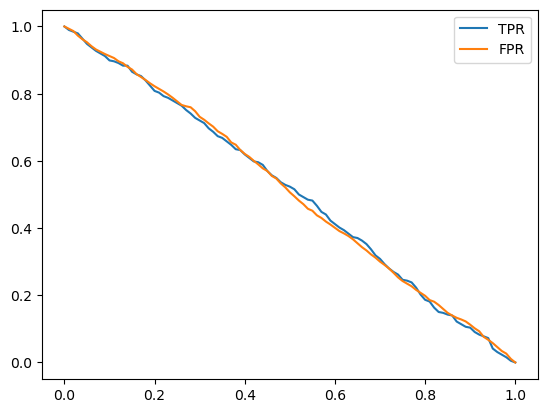

In [56]:
plt.plot(df_rand.thr, df_rand.tpr, label="TPR")
plt.plot(df_rand.thr, df_rand.fpr, label="FPR")
plt.legend()

In [85]:
n_pos = (y_val == 1).sum()
n_neg = (y_val == 0).sum()
print(n_pos, n_neg)
y_perfect = np.repeat([0, 1], [n_neg, n_pos])
y_perfect_pred = np.linspace(0, 1, len(y_val))

386 1023


In [82]:
(1 - y_val.mean()).item()

0.7260468417317246

In [86]:
accuracy_score(y_perfect, y_perfect_pred > (1 - y_val.mean()))

1.0

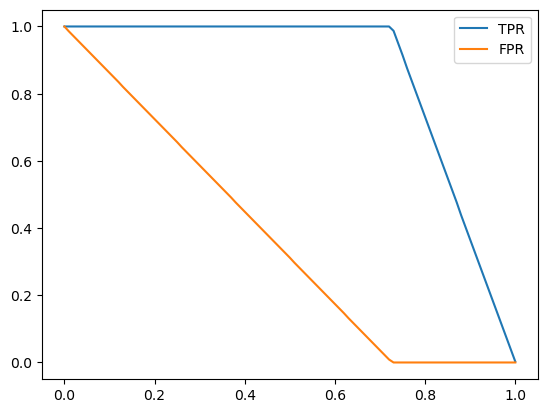

In [87]:
df_perfect = tpr_fpr(y_perfect, y_perfect_pred)

plt.plot(df_perfect.thr, df_perfect.tpr, label="TPR")
plt.plot(df_perfect.thr, df_perfect.fpr, label="FPR")
plt.legend()

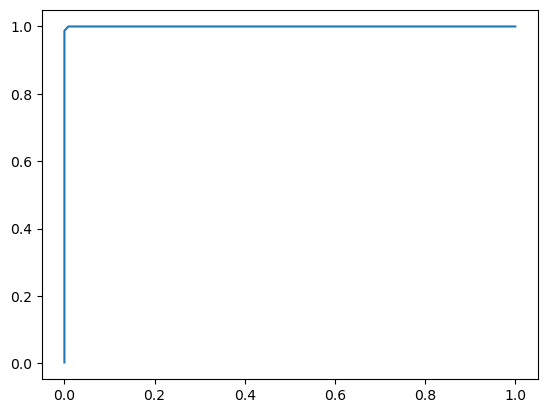

In [88]:
plt.plot(df_perfect.fpr, df_perfect.tpr, label="perfect")

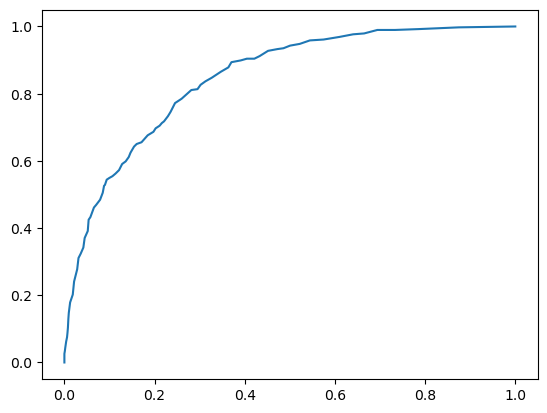

In [89]:
plt.plot(df.fpr, df.tpr, label="model")

In [90]:
from sklearn.metrics import roc_curve

In [93]:
fpr, tpr, t = roc_curve(y_val, y_pred)

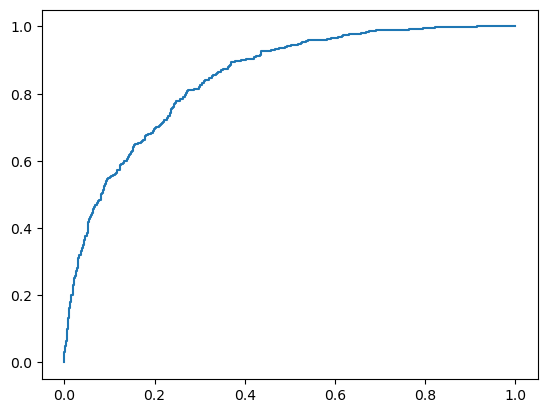

In [94]:
plt.plot(fpr, tpr, label="model")

In [95]:
from sklearn.metrics import auc

In [97]:
auc(df.fpr, df.tpr)

np.float64(0.8458903762681133)

In [98]:
auc(df_rand.fpr, df_rand.tpr)

np.float64(0.49967711546351024)

In [99]:
auc(df_perfect.fpr, df_perfect.tpr)

np.float64(0.9999430203759136)

# Crossvalidation

In [103]:
def train(df, y_train):
    dicts = df[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(dicts)
    model = LogisticRegression(max_iter=20_000)
    model.fit(X, y_train)
    return dv, model

In [104]:
dv, model = train(df_train, y_train)

In [105]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    return model.predict_proba(X)[:, 1]

In [107]:
y_pred = predict(df_val, dv, model)

In [108]:
from sklearn.model_selection import KFold

In [109]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [112]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [113]:
# each generator call returns 90% train, 10% val permutation

len(train_idx), len(val_idx)

(5070, 564)

In [114]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [119]:
from sklearn.metrics import roc_auc_score
import tqdm

scores = []

for train_idx, val_idx in tqdm.tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    roc_auc = roc_auc_score(y_val, y_pred)
    scores.append(roc_auc)

10it [00:04,  2.46it/s]


In [120]:
scores

[np.float64(0.8498004230078081),
 np.float64(0.8424040841584159),
 np.float64(0.8585286447519226),
 np.float64(0.833272981647601),
 np.float64(0.8246122828784119),
 np.float64(0.8411255411255409),
 np.float64(0.8431618365353305),
 np.float64(0.8255297280202403),
 np.float64(0.8458574181117533),
 np.float64(0.8612147490840644)]

In [121]:
np.mean(scores), np.std(scores)

(np.float64(0.8425507689321089), np.float64(0.011692462232987701))

# Parameter tuning

In [122]:
def train(df, y_train, C=1.):
    dicts = df[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(dicts)
    model = LogisticRegression(max_iter=20_000, C=C)
    model.fit(X, y_train)
    return dv, model

In [123]:
dv, model = train(df_train, y_train, C=0.001)

In [125]:
n_splits = 5

for C in tqdm.tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 14%|█▍        | 1/7 [00:00<00:03,  1.50it/s]

C=0.001 0.825 +- 0.009


 29%|██▊       | 2/7 [00:02<00:05,  1.16s/it]

C=0.01 0.840 +- 0.008


 43%|████▎     | 3/7 [00:05<00:08,  2.13s/it]

C=0.1 0.842 +- 0.007


 57%|█████▋    | 4/7 [00:07<00:06,  2.10s/it]

C=0.5 0.842 +- 0.007


 71%|███████▏  | 5/7 [00:09<00:04,  2.17s/it]

C=1 0.842 +- 0.007


 86%|████████▌ | 6/7 [00:12<00:02,  2.31s/it]

C=5 0.842 +- 0.007


100%|██████████| 7/7 [00:14<00:00,  2.10s/it]

C=10 0.842 +- 0.007
